# Clasification! - Extra

Suppose I told you my model had a 98% accuracy rate. The question is, is the model good or bad?

The real answer is that it depends. If I told you that in the dataset, 98% had the label 0 and 2% had the label 1 this result is not impressive anymore (highly imbalanced data). Because your model can simply be $\hat{y} = 0$ and you get a 98% accuracy rate. Now lets look at the confusion matrix

|            | $Y_{pred} = 0$ | $Y_{pred} = 1$ |
|------------|--------------|--------------|
|$Y_{true} = 0$|        True Negatives     |     False Positives      | 
|$Y_{true} = 1$|  False Negatives         |      True Positives       |

$$\textrm{Accuracy} = \frac{\textrm{True Negatives} + \textrm{True Positives}}{\textrm{Number of Samples}}$$

$$ \textrm{Precision} = \frac{\textrm{True Positives}}{\textrm{True Positives + False Positives}}$$


### Ideal Model (Accuracy 100%)

|            | $Y_{pred} = 0$ | $Y_{pred} = 1$ |
|------------|--------------|--------------|
|$Y_{true} = 0$|        98     |     0      | 
|$Y_{true} = 1$|  0        |      2       |


$$ \textrm{Precision} = \frac{2}{2}=1$$
<br>
<br>

 
### Model: `y = 0` (Accuracy 98%)

|            | $Y_{pred} = 0$ | $Y_{pred} = 1$ |
|------------|--------------|--------------|
|$Y_{true} = 0$|        98     |     0      | 
|$Y_{true} = 1$|  2         |      0       |


$$ \textrm{Precision} = \frac{0}{0 + 0}=... \textrm{math}...=0$$
<br>
<br>
### Model: Flipping a Coin (Accuracy 50%)
|            | $Y_{pred} = 0$ | $Y_{pred} = 1$ |
|------------|--------------|--------------|
|$Y_{true} = 0$|        49     |     49      | 
|$Y_{true} = 1$|  1         |      1       |

$$ \textrm{Precision} = \frac{1}{1 + 49}=0.02$$


Now, if I ask you that this data was on cancer cells
- label 0: No Cancer
- label 1: Has Cancer

It would seem that flipping a coin (50% accuracy) is much better than 99% accuracy.

### Model: High Bias (Accuracy 2%)
|            | $Y_{pred} = 0$ | $Y_{pred} = 1$ |
|------------|--------------|--------------|
|$Y_{true} = 0$|        0     |     98      | 
|$Y_{true} = 1$|  0         |      2       |

$$ \textrm{Precision} = \frac{2}{2 + 98}=0.02$$

Once again, having a model with high bias proves to be the winner again. But, once again, we need to think if this makes sense or not. In this model with high bias, all patients who have cancer have been correctly identified as having cancer. But, this comes at the cost of all patients who DON'T have cancer being identified as having cancer. As such, patients who have cancer are given need treatment, like radio-therapy, while patients who don't have cancer are also given radio-therapy. 

Once again, real world modelling is no longer a question of statistics. It is a question of morality and ethics. The real question is, what percentage of error do we accept as being okay, or morally good?

<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Tutorial 8: Logistic Regression</h2>
<br>

In this tutorial we discuss how we you can use the logistic regression method in practical business decision-making application to credit risk. 

<a href="#1.-German-Credit-Data">German credit data</a> <br>
<a href="#2.-Business-understanding">Business understanding</a> <br>
<a href="#3.-Exploratory-Data-Analysis">Exploratory data analysis</a> <br>
<a href="#4.-Feature-engineering">Feature Engineering</a> <br>
<a href="#5.-Logistic-regression">Logistic Regression</a> <br>
<a href="#6.-Feature-selection">Feature selection</a> <br>
<a href="#7.-Evaluation">Evaluation</a> <br>

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Model selection and evaluation tools
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, log_loss

## 1. German credit data

This tutorial is based on the [German Credit Data](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) available from the UCI Machine Learning repository. Each observation in the dataset represents a loan. The response variable is `default`, which indicates whether the client defaulted on the loan. 

In [4]:
data = pd.read_csv('Data/german_credit.csv')
data.head()

,status,duration,history,purpose,amount,savings,employment,installment_rate,personal,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,people_under_maintenance,telephone,foreign_worker,default
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,1,1,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,0,1,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,0,1,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,0,1,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,0,1,1


There are 13 categorical predictors (two of them binary and already coded numerically) and 7 numerical predictors in the dataset. Refer to the [documentation](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) for the explanation of the variables and the meaning of the levels for the categorical variables. 

In [5]:
variables = pd.read_csv('Data/german_credit_variables.csv', index_col='variable')
variables = variables['type']

continuous = variables[variables == 'continuous'].index.tolist()
discrete = variables[variables == 'discrete'].index.tolist()
categorical = variables[variables == 'categorical'].index.tolist()
binary = variables[variables == 'binary'].index.tolist()
response = variables[variables == 'response'].index.tolist()
   
variables.value_counts()

categorical    11
discrete        4
continuous      3
binary          2
response        1
Name: type, dtype: int64

As usual, we first split the data. For now we only need to create an unprocessed version of the training data. 

In [6]:
index_train, index_test  = train_test_split(np.array(data.index), stratify=data[response], 
                                            train_size=0.7, random_state=5)
train = data.loc[index_train,:].copy()

## 2. Business understanding

The data documentation specifies the following loss matrix: 

<table>
  <tr>
    <th>Actual/ Predicted</th>
    <th>Repayment</th>
     <th>Default</th>
  </tr>
  <tr>
    <th>Repayment</th>
    <td>0</td>
    <td>1</td>
  </tr>
  <tr>
    <th>Default</th>
    <td>5</td>
    <td>0</td>
  </tr>
</table>

That is, if we predict a default but the client is a good credit, the loss is 1.  If we predict that the client will repay the loan but there is a default, the loss is 5. The loss for a correct classification is 0. In general terminology, we say that the loss from a false positive is 1, the loss from a false negative is 5, and the loss from both true positives and true negatives is zero. 

Using the formula from the lecture, the decision threshold is: 

In [7]:
tau = 1/(1+5)
print(f'Decision threshold: tau={round(tau,3)}')

Decision threshold: tau=0.167


If the probability of default is lower than 0.167, then we should classify the client as creditworthy. If the probability of default is higher than 0.167, then we should classify the loan as high risk. 

## 3. Exploratory Data Analysis


### 3.1 Descriptive statistics

The descriptive statistics allows us to verify that there are no missing values or apparent errors in the numerical variables.

In [8]:
train.describe().round(2)

,duration,amount,installment_rate,residence,age,existing_credits,people_under_maintenance,telephone,foreign_worker,default
count,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00
mean,21.12,3346.50,2.97,2.84,35.67,1.43,1.16,0.41,0.97,0.30
std,12.26,2870.26,1.13,1.11,11.60,0.59,0.37,0.49,0.18,0.46
min,4.00,250.00,1.00,1.00,20.00,1.00,1.00,0.00,0.00,0.00
25%,12.00,1364.00,2.00,2.00,27.00,1.00,1.00,0.00,1.00,0.00
50%,18.00,2339.50,3.00,3.00,33.00,1.00,1.00,0.00,1.00,0.00
75%,24.00,4151.50,4.00,4.00,42.00,2.00,1.00,1.00,1.00,1.00
max,60.00,15945.00,4.00,4.00,75.00,4.00,2.00,1.00,1.00,1.00


### 3.2 Response variable

Defaults occur in 30% of the loans in the training data. 


In [9]:
train['default'].value_counts(normalize=True)

0    0.7
1    0.3
Name: default, dtype: float64

### 3.3 Continuous predictors 

As common in this type of data, some of the continuous variables are skewed. 

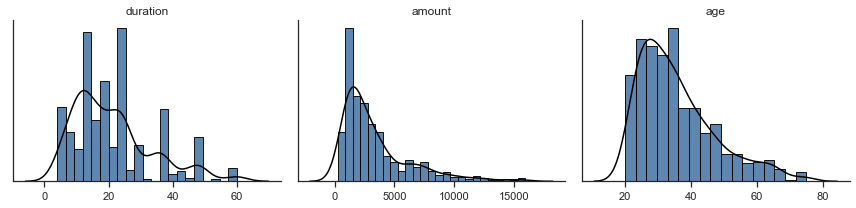

In [10]:
from statlearning import plot_dists
plot_dists(train[continuous]) 
plt.show()

## 3.4 Bivariate relationships

The duration and amount of the loan seem to have a relevant positive association with the default rates.

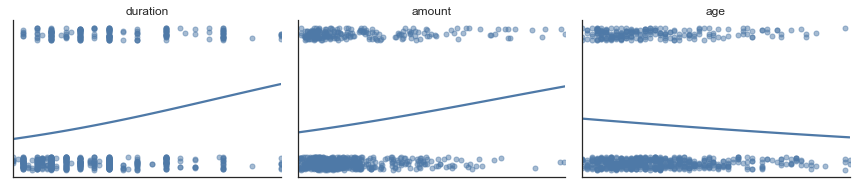

In [11]:
from statlearning import plot_logistic_regressions
fig, ax = plot_logistic_regressions(train[continuous], train['default'])
plt.show()

As we discussed in an earlier tutorial, it's often useful to estimate the strength of association between the response and the predictors. Because the response is binary, we should ideally use a measure of dependence that is more informative for this type of relationship (unlike for example a correlation, which limited to measuring linear dependence). 

Below, we estimate the [mutual information](https://en.wikipedia.org/wiki/Mutual_information). The details of this method are beyond the scope of this unit, but a mutual information of zero suggests no dependence, and higher values mean stronger dependence. Unfortunately, the estimator can have high variance. 

In [12]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(train[continuous], train['default'], random_state=1)
pd.DataFrame(mi, index=continuous, columns=['MI']).round(4)

,MI
duration,0.0296
amount,0.0204
age,0.0113


In [13]:
mi = mutual_info_classif(train[discrete +binary], train['default'], n_neighbors=5, random_state=10, discrete_features=True)
pd.DataFrame(mi, index=discrete+binary, columns=['MI']).round(4)

,MI
installment_rate,0.0045
residence,0.0010
existing_credits,0.0008
people_under_maintenance,0.0005
telephone,0.0004
foreign_worker,0.0077


The following  plots allow us to visualise the relationship between `default` and the remaining variables. Certain variables, such as the status of existing checking account, saving, credit history, and whether the client is a foreign worker, seem to have an important association with the default rates.

In [14]:
predictor = 'installment_rate'

predictor_n_out = train.loc[:, [predictor, 'default']]

for p in sorted(predictor_n_out[predictor].unique()):
    split = predictor_n_out[predictor_n_out[predictor] == p]
    print(p, split['default'].mean())

1 0.25
2 0.25316455696202533
3 0.2777777777777778
4 0.344311377245509


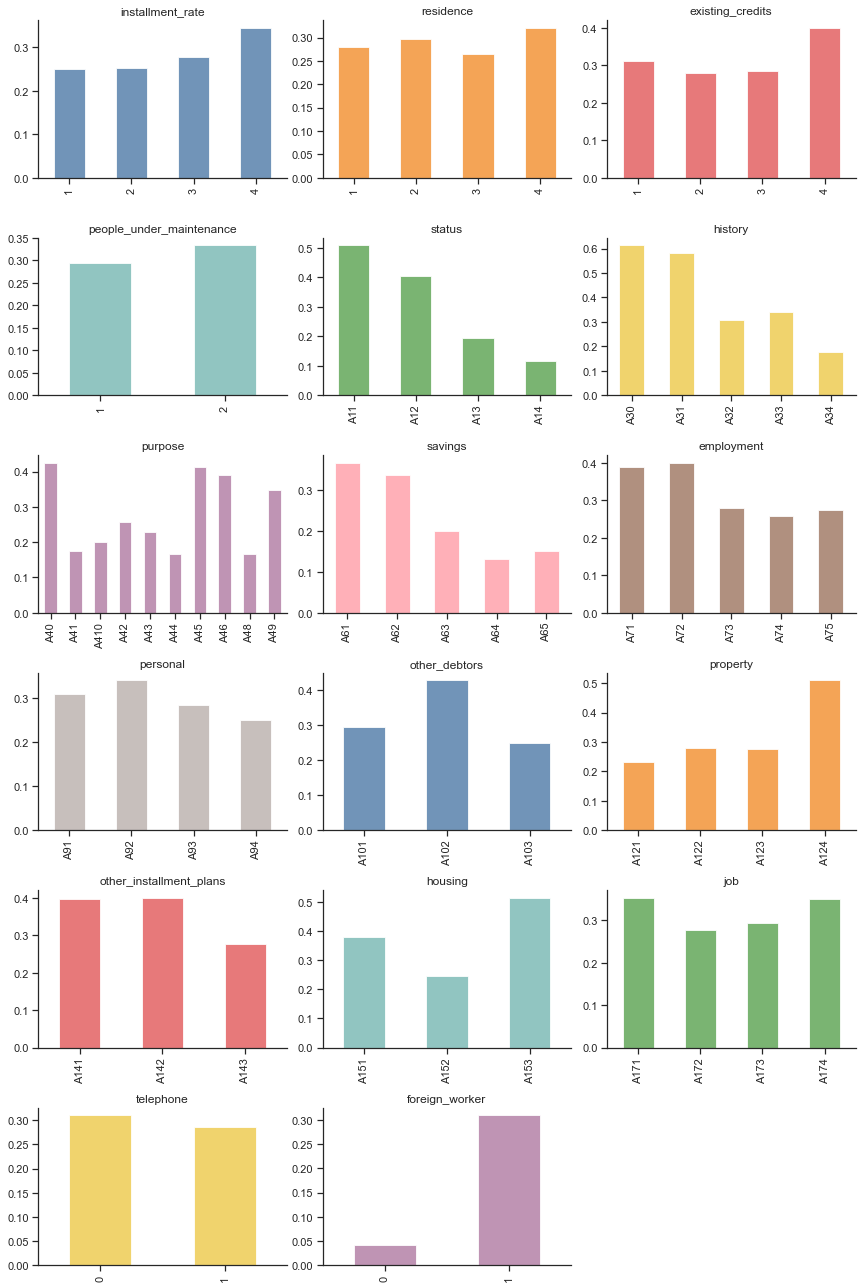

In [15]:
from statlearning import crosstabplots
crosstabplots(train[discrete + categorical + binary], train['default'])
plt.show()

# Aside - ML and Morality

Phrenology, a quick-science or pseudo-science, where people used to believed the measurement of bumps on the skull can be used to predict mental intellegence. Phrenology is no-longer studied, and in fact is more used as an insult to someones work.

It is for this reason that if you are an acturary and want to predict the life expectency of an individual you can't use traits such as gender and ethnicity.

Unfortunately a form of phrenology is comming back in machine learning. 

### Facial Recognition and Criminals
There was a research, about 5 years ago, where the researchers used deep learning to see if they can predict someone has commited a crime based on their face. Interetingly they were able to get pretty good results. When the researchers published the results they got A LOT of push back from social media, and the researchers published a follow up paper to defend their work. They defended their work by saying that we are simply trying to see the limits of machine learning techniques.

While they can defend their work by claiming ignorance, the effect of this paper is that there are certain facial features, as detected by the algorithm, that can be used to determine if you will commit a crime or not. Meaning that you don't need to commit a crime, but so long as you possess features that the algorithm determines to be important, then you are just as guilty as a person who did commit the crime.

### Lecun
About 3 months ago, famous ML researcher Lecun made a comment on twitter:

    ML systems are biased when data is biased. This face upsampling system makes everyone look white because the network was pretrained on FlickFaceHQ, which mainly contains white people pics. Train the exact same system on a dataset from Senegal, and everyone will look African. - Lecun
    
Lecun got a lot of back lash from this comment. Essentially saying that our models aren't bias, it is simply the dataset that is bias. But, really, it is the role of us, the modelers, to ensure that our dataset is sampled fairly. With out any bias. As such, any resulting bias that comes into our model is really our fault. In fact Lecun even says this, why not combine the Senegal and LickFaceHQ dataset. The combination would be a fairer representation of reality, so why not do that?

### Why Am I Talking About This
Because it is important.

But, more to the point, we can actually make our models better if we recognise this. It should be obvious, the features of a person (age, income, education, do they have criminal contacts, etc.) are going to be far better predictors of criminality rather than their face.

We even did this in our tutorials. When we predict the credit card balance of an individual, if you look at the result of the regression you see that 

| Predictor | Regression Coeff |
|--------------|--------------|
| African American | -8.145 |
| Asian | 6.476 |

Our model is saying that by virtue of being asian you have +6, and by virtue of being African American you have = -8. But I'd argue that your race (or your gender) has nothing to do with your credit card balance. It is probably other socio-economic factors.

Take a look at median ages

| Country | Median Age (Years) |
|--------------|--------------|
| Japan | 48.4 |
| America | 37.8 |

It seems, then, by virtue of being Japanese you have a longer life expectancy. But, in reality, it probably has more to do with socio-economic factors. For example food deserts

    A food desert is an area that has limited access to affordable and nutritious food, in contrast with an area with higher access to supermarkets or vegetable shops with fresh foods, which is called a food oasis.
Japan has great access to fresh and nutrious food, but in America
    
    In 2010, the United States Department of Agriculture reported that 23.5 million people in the U.S. live in "food deserts", meaning that they live more than one mile [(1.6 km or 15-20 min walk)] from a supermarket in urban or suburban areas and more than 10 miles [(about 2 hour walk)] from a supermarket in rural areas

More to the point, rather than using these generic attributes like race, gender, and facial structure, if you did a bit more studying on the topic you can come up with far better predictors.

### Moral
The moral of this story is that one can get into trouble really quickly when blindly making models. So if you do go into the real world, be careful.

## 4. Feature Engineering

We create a function that implements the feature engineering process below. Here are the key details: 

1. Yeo-Johnson transformation for the credit amount and age. The code allows you to verify that these transformations help. 

2. Dummy encoding for the categorical variables, noting that they all have low cardinality. 

3. We treat the discrete variables in the same way as categorical variables (since they only have a few possible values).

4. We standardise the predictors (not strictly necessary, but it makes the optimisation algorithm more stable). 

In [16]:
from sklearn.preprocessing import PowerTransformer, StandardScaler

def feat_engineering(df, variables, dummy=True, transformation=True):
    
    data = df.copy()
    
    continuous = variables[variables == 'continuous'].index.tolist()
    discrete = variables[variables == 'discrete'].index.tolist()
    categorical = variables[variables == 'categorical'].index.tolist()
    binary = variables[variables == 'binary'].index.tolist()
    response = variables[variables == 'response'].index.tolist()
    
    # Dummy or one-hot encoding for all discrete and categorical variables
    labels = discrete + categorical 
    for label in labels:
        if dummy:
            dummies = pd.get_dummies(data[label], prefix=label, drop_first=True)
        else:
            dummies = pd.get_dummies(data[label], prefix=label)
        data = data.join(dummies)
        binary += list(dummies.columns)
    
    # Yeo-Johnson transformation
    transf = ['amount', 'age']
    if transformation: 
        yj_transf = PowerTransformer(method='yeo-johnson').fit(data.loc[index_train, transf])
        data[transf] = yj_transf.transform(data[transf])
    
    predictors = continuous + binary
    scaler = StandardScaler().fit(data.loc[index_train, predictors])
    data[predictors] = scaler.transform(data[predictors])
    
    X_train = data.loc[index_train, predictors]
    X_test = data.loc[index_test, predictors]

    y_train = data.loc[index_train, response].to_numpy()
    y_test = data.loc[index_test, response].to_numpy()
    
    return X_train, np.ravel(y_train), X_test, np.ravel(y_test), predictors

X_train, y_train, X_test, y_test, predictors = feat_engineering(data, variables)

## 5. Logistic Regression

We consider the logistic regression algorithm for classification. 

In [17]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(C=np.inf) # the C=np.inf option avoids the default regularisation
logit.fit(X_train, y_train)

# Can instead use 
# logit = LogisticRegression(penalty = 'none')

LogisticRegression(C=inf, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The next figure shows the largest estimated coefficients of the trained model. This can help us to interpret the model. 

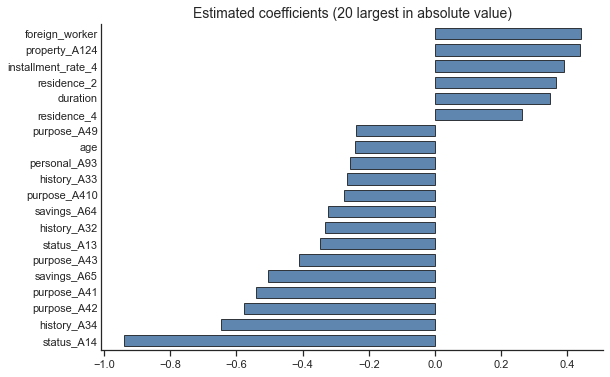

In [18]:
from statlearning import plot_coefficients
plot_coefficients(logit, predictors)
plt.show()

## 6. Feature selection

We have 54 features, which is a moderate number for the size of the training data. Therefore, we consider the forward selection algorithm like last week. The next cell may take a couple of minutes to run. 

In [19]:
%%time 

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# You may want to add verbose=2 to track the progress
fwd = SFS(LogisticRegression(C=np.inf), k_features='best', forward=True, cv=10, scoring='neg_log_loss')
fwd.fit(X_train, y_train)
subset = fwd.k_feature_idx_ # we need the numerical indexes for later

Wall time: 1min 1s


The algorithm selects 21 out of 54 original features.

In [20]:
len(subset)

21

Like last week, it's instructive to plot the cross-validation performance as a function of the number of predictors. Note that the package plots minus the cross-validation error, therefore the familiar bowl shape is inverted. 

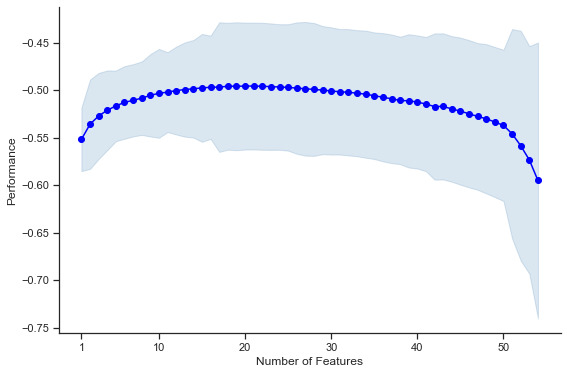

In [21]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig, ax = plot_sfs(fwd.get_metric_dict(), kind='std_dev') 
ax.set_xticks([1,10,20,30,40,50])
sns.despine()
plt.show()

Based on these results, we choose this version of the logistic regression model with selected features as the final model for this tutorial. In a full project, we should analyse validation set or cross-validation results in more detail as we do below in evaluation. 

In [22]:
from sklearn.pipeline import make_pipeline
from mlxtend.feature_selection import ColumnSelector

logit_ss = make_pipeline(ColumnSelector(cols=subset), LogisticRegression(C=np.inf))
logit_ss.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columnselector',
                 ColumnSelector(cols=[0, 2, 7, 11, 15, 16, 17, 21, 22, 24, 25,
                                      30, 31, 33, 34, 37, 39, 43, 46, 48, 49],
                                drop_axis=False)),
                ('logisticregression',
                 LogisticRegression(C=inf, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

## 7. Evaluation

As usual, our main objective in evaluation is to estimate the risk of the final classifier. This should be a direct measure of the business value of the learned model. 

Here's the interpretation of the other metrics: 

**Sensitivity:** the model correctly predicted 85.6% of defaults in the test set.

**Specificity:** the model correctly predicted 46.7% of repayments in the test set.

**Precision:** out of the loans that we were classified as high risk on the test set, 40.7% were actual defaults. 

**AUC:** the AUC is a measure (between 0 and 1, with 0.5 corresponding to an uninformative classifier) of how well the model can balance sensitivity and specificity. The better the model predicts the condititional probability of default, the higher the AUC is.

**NLL** (negative log-likelihood): we'll discuss this in Lecture 8, but lower values are better.  

In [23]:
logit_ss.predict(X_train)[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
      dtype=int64)

In [24]:
# First column is the probability that the label is 0
# Second column is the probability that the label is 1
logit_ss.predict_proba(X_train)

array([[0.89304618, 0.10695382],
       [0.70047736, 0.29952264],
       [0.6151596 , 0.3848404 ],
       ...,
       [0.52825885, 0.47174115],
       [0.65961473, 0.34038527],
       [0.87496815, 0.12503185]])

In [25]:
print(tau)

0.16666666666666666


In [26]:
(logit_ss.predict_proba(X_train)[:, 1] > tau)[:5]

array([False,  True,  True,  True,  True])

In [27]:
columns=['Estimated risk', 'SE', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'NLL']
rows=['Logistic Regression', 'Logistic Regression (feature selection)']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, logit_ss]

y_test = np.ravel(y_test)
y_prob = np.zeros((len(y_test), len(rows)))

for i, method in enumerate(methods):    
    
    y_prob[:,i] = method.predict_proba(X_test)[:,1]
    y_pred = (y_prob[:,i] > tau).astype(int)

    loss =  5*((y_pred!=y_test) & (y_pred==0)) + 1*((y_pred!=y_test) & (y_pred==1))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 

    results.iloc[i,0] =  np.mean(loss) # or (fp*1+fn*5)/len(y_test)
    results.iloc[i,1] =  np.std(loss)/np.sqrt(len(y_test))
    results.iloc[i,2] =  tp/(tp+fn)
    results.iloc[i,3] =  tn/(tn+fp)
    results.iloc[i,4] =  precision_score(y_test, y_pred)
    results.iloc[i,5] =  roc_auc_score(y_test, y_prob[:,i])
    results.iloc[i,6] =  log_loss(y_test, y_prob[:,i])

results.round(3)

,Estimated risk,SE,Sensitivity,Specificity,Precision,AUC,NLL
Logistic Regression,0.67,0.072,0.778,0.519,0.409,0.737,0.555
Logistic Regression (feature selection),0.59,0.061,0.856,0.467,0.407,0.761,0.521



|            | $Y_{pred} = 0$ | $Y_{pred} = 1$ |
|------------|--------------|--------------|
|$Y_{true} = 0$|        True Negatives     |     False Positives      | 
|$Y_{true} = 1$|  False Negatives         |      True Positives       |

$$\textrm{Sensitivity} = \frac{\textrm{True Positives}}{\textrm{Actual Positives}} = \frac{\textrm{TP}}{\textrm{TP + FN}}$$

$$\textrm{Specificty} = \frac{\textrm{True Negatives}}{\textrm{Actual Negatives}} = \frac{\textrm{TN}}{\textrm{TN + FP}}$$

- Sensitivity: Of the data points with label 1, how many did you get CORRECT
- Specificty:  Of the data points with label 0, how many did you get CORRECT

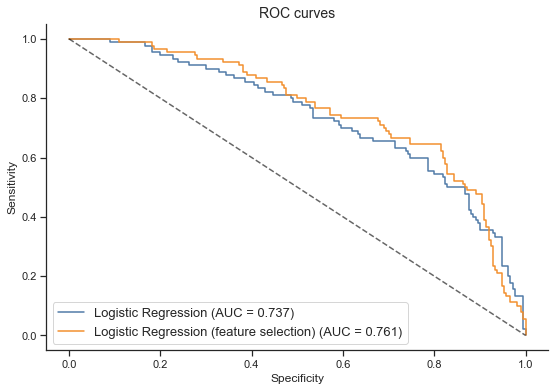

In [28]:
from statlearning import plot_roc_curves

fig, ax = plot_roc_curves(y_test, y_prob, labels=pd.Series(rows))
plt.show()

In [29]:
from sklearn.metrics import roc_curve

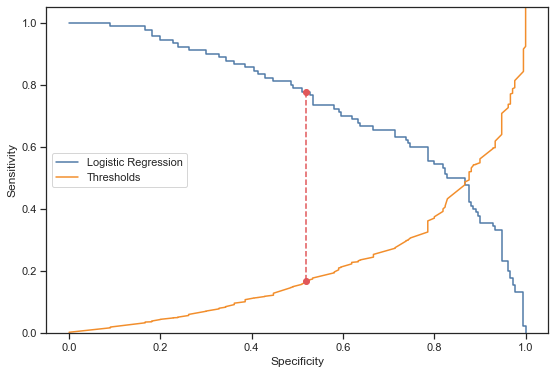

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,0])
plt.plot(1-fpr, tpr, label = 'Logistic Regression')
plt.plot(1-fpr, thresholds, label = 'Thresholds')
plt.plot([0.519, 0.519], [0.778, tau], 'o--')
plt.legend();
plt.ylim(0, 1.05);
plt.ylabel('Sensitivity')
plt.xlabel('Specificity');

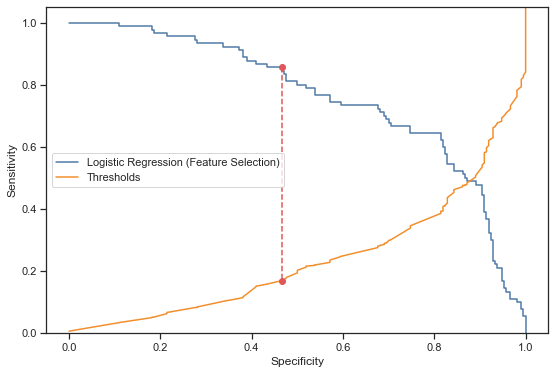

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
plt.plot(1-fpr, tpr, label = 'Logistic Regression (Feature Selection)')
plt.plot(1-fpr, thresholds, label = 'Thresholds')
plt.plot([0.467, 0.467], [0.856, tau], 'o--')
plt.legend();
plt.ylim(0, 1.05);
plt.ylabel('Sensitivity')
plt.xlabel('Specificity');

### Formatting

These two cells below format the notebook for display online. Please omit them from your work.

In [32]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [33]:
from IPython.core.display import HTML
style = open('css\jupyter.css', "r").read()
HTML('<style>'+ style +'</style>')

FileNotFoundError: [Errno 2] No such file or directory: 'css\\jupyter.css'

Hi Chok, in feature selection,the algorithm selects 21 out of 54 original features, but I think is still too many features ,so is this the situation we can  apply PCA?


In [ ]:
len(X_train)

In [ ]:
0.9*700